In [1]:
!pip install svgwrite cairosvg


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install svgwrite


[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


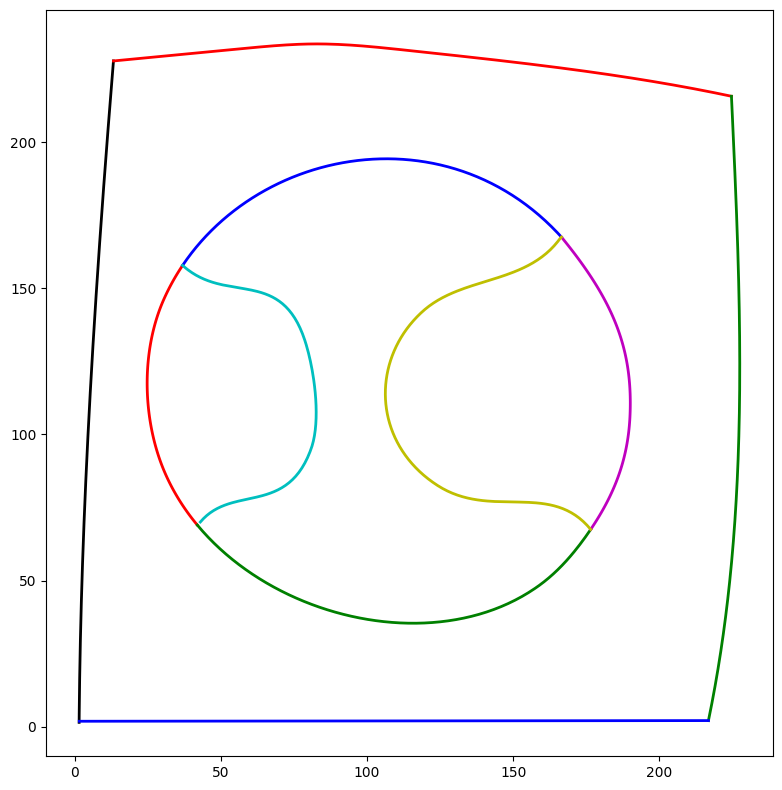

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
    colours = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    plt.show()

# Example usage:
path_XYs = read_csv('dataset/frag0.csv')

plot(path_XYs)

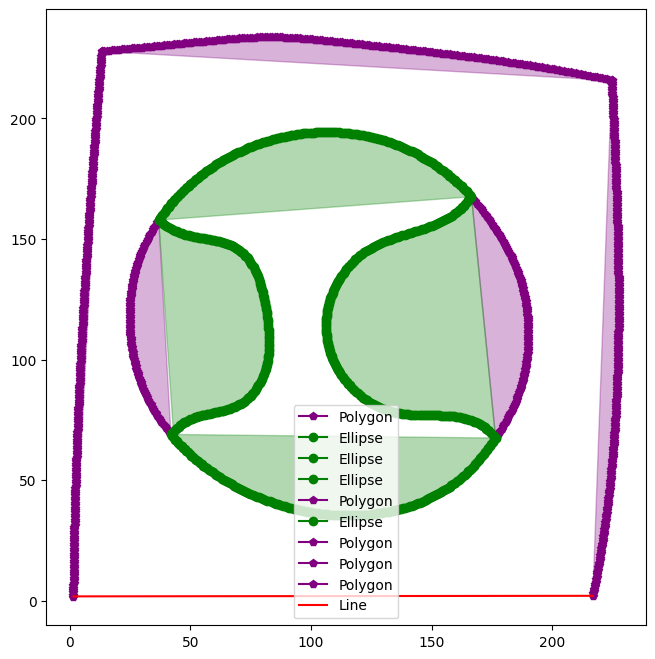

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def is_straight_line(XY):
    """Check if points form a straight line."""
    if len(XY) < 2:
        return False
    XY = np.array(XY)
    x = XY[:, 0]
    y = XY[:, 1]
    
    # Fit a line to the points
    coeffs = np.polyfit(x, y, 1)
    y_fit = np.polyval(coeffs, x)
    residuals = np.abs(y - y_fit)
    
    return np.all(residuals < 1e-1)

def is_circle(XY):
    """Check if points form a circle."""
    if len(XY) < 3:
        return False
    XY = np.array(XY)
    center = XY.mean(axis=0)
    distances = np.linalg.norm(XY - center, axis=1)
    return np.allclose(distances, distances.mean(), atol=1e-1)

def is_ellipse(XY):
    """Check if points form an ellipse."""
    if len(XY) < 5:
        return False
    XY = np.array(XY)
    center = XY.mean(axis=0)
    distances = np.linalg.norm(XY - center, axis=1)
    distances_mean = distances.mean()
    distances_std = distances.std()
    return distances_std / distances_mean < 0.5

def is_rectangle(XY):
    """Check if points form a rectangle."""
    if len(XY) != 4:
        return False
    XY = np.array(XY)
    dists = distance.pdist(XY, 'euclidean')
    dists = np.round(dists, 2)
    unique_dists = np.unique(dists)
    if len(unique_dists) == 2:
        sides = min(unique_dists)
        diagonals = max(unique_dists)
        return np.allclose(sides * np.sqrt(2), diagonals, atol=1e-1)
    return False

def is_regular_polygon(XY):
    """Check if points form a regular polygon."""
    if len(XY) < 3:
        return False
    XY = np.array(XY)
    center = XY.mean(axis=0)
    vectors = XY - center
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])
    angles = np.mod(angles, 2 * np.pi)
    angle_diffs = np.diff(np.sort(angles))
    angle_diffs = np.append(angle_diffs, 2 * np.pi - angle_diffs[-1])
    return np.allclose(np.mean(angle_diffs), 2 * np.pi / len(XY), atol=1e-1)

def is_star_shape(XY):
    """Check if points form a star shape."""
    if len(XY) < 5:
        return False
    XY = np.array(XY)
    center = XY.mean(axis=0)
    vectors = XY - center
    angles = np.arctan2(vectors[:, 1], vectors[:, 0])
    angles = np.mod(angles, 2 * np.pi)
    angle_diffs = np.diff(np.sort(angles))
    angle_diffs = np.append(angle_diffs, 2 * np.pi - angle_diffs[-1])
    return np.any(angle_diffs > 2 * np.pi / len(XY))

def regularize_shapes(paths_XYs):
    regular_shapes = []
    for XYs in paths_XYs:
        for XY in XYs:
            if is_straight_line(XY):
                regular_shapes.append(('Line', XY))
            elif is_circle(XY):
                regular_shapes.append(('Circle', XY))
            elif is_ellipse(XY):
                regular_shapes.append(('Ellipse', XY))
            elif is_rectangle(XY):
                regular_shapes.append(('Rectangle', XY))
            elif is_regular_polygon(XY):
                regular_shapes.append(('Polygon', XY))
            elif is_star_shape(XY):
                regular_shapes.append(('Star', XY))
            else:
                regular_shapes.append(('Irregular', XY))
    return regular_shapes

def plot_regularized_shapes(regular_shapes):
    fig, ax = plt.subplots(figsize=(8, 8))
    colors = {'Line': 'red', 'Circle': 'blue', 'Ellipse': 'green', 'Rectangle': 'yellow', 'Polygon': 'purple', 'Star': 'orange', 'Irregular': 'black'}
    markers = {'Line': None, 'Circle': 'o', 'Ellipse': 'o', 'Rectangle': 's', 'Polygon': 'p', 'Star': '*', 'Irregular': 'x'}
    for shape, XY in regular_shapes:
        XY = np.array(XY)
        if markers[shape] is not None:
            ax.plot(XY[:, 0], XY[:, 1], label=shape, color=colors[shape], marker=markers[shape])
        else:
            ax.plot(XY[:, 0], XY[:, 1], label=shape, color=colors[shape])
        if shape in ['Circle', 'Ellipse', 'Rectangle', 'Polygon', 'Star']:
            ax.fill(XY[:, 0], XY[:, 1], color=colors[shape], alpha=0.3)  # Fill shapes for better visualization
    ax.legend()
    ax.set_aspect('equal')
    plt.show()

# Example usage:
path_XYs = read_csv('dataset/frag0.csv')  # Replace with your actual CSV file path
regular_shapes = regularize_shapes(path_XYs)
plot_regularized_shapes(regular_shapes)


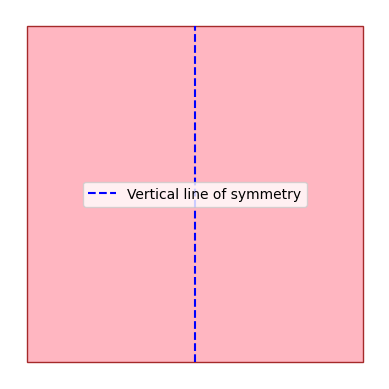

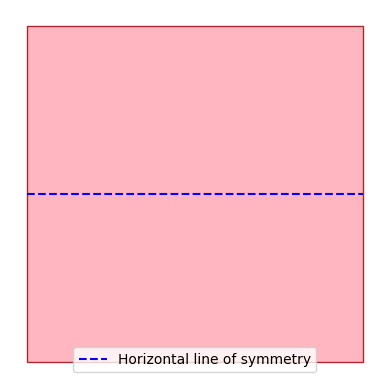

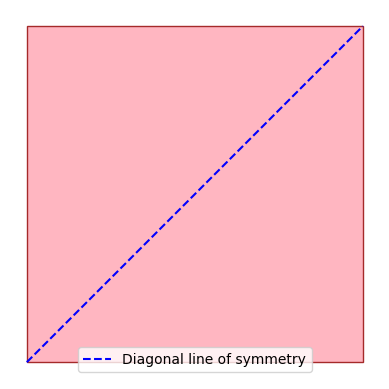

In [6]:
import numpy as np
import matplotlib.pyplot as plt


# Function to generate points for a square
def generate_square_points(center, side_length):
    half_side = side_length / 2
    points = np.array([
        [center[0] - half_side, center[1] - half_side],
        [center[0] - half_side, center[1] + half_side],
        [center[0] + half_side, center[1] + half_side],
        [center[0] + half_side, center[1] - half_side],
        [center[0] - half_side, center[1] - half_side]  # Close the square
    ])
    return points


# Function to plot a square and its lines of symmetry
def plot_square_and_symmetry(square_points, symmetry_line, line_label):
    center = np.mean(square_points[:-1], axis=0)

    plt.fill(square_points[:, 0], square_points[:, 1], 'lightpink', edgecolor='brown')

    if symmetry_line == 'vertical':
        plt.plot([center[0], center[0]], [square_points[0][1], square_points[2][1]], 'b--', label=line_label)
    elif symmetry_line == 'horizontal':
        plt.plot([square_points[0][0], square_points[2][0]], [center[1], center[1]], 'b--', label=line_label)
    elif symmetry_line == 'diagonal1':
        plt.plot([square_points[0][0], square_points[2][0]], [square_points[0][1], square_points[2][1]], 'b--',
                 label=line_label)

    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.axis('off')
    plt.show()


# Parameters for the square
center = (0, 0)
side_length = 10

# Generate square points
square_points = generate_square_points(center, side_length)

# Plot square with vertical line of symmetry
plt.figure()
plot_square_and_symmetry(square_points, 'vertical', 'Vertical line of symmetry')

# Plot square with horizontal line of symmetry
plt.figure()
plot_square_and_symmetry(square_points, 'horizontal', 'Horizontal line of symmetry')

# Plot square with diagonal line of symmetry (bottom-left to top-right)
plt.figure()
plot_square_and_symmetry(square_points, 'diagonal1', 'Diagonal line of symmetry')


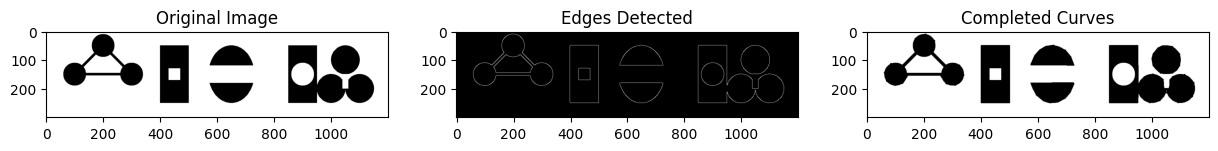

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Function to draw shapes similar to the provided image
def create_test_image(image_path):
    # Create a blank white image
    image_size = (300, 1200)
    white = (255, 255, 255)

    # Create a blank image with a white background
    image = np.ones((image_size[0], image_size[1], 3), dtype=np.uint8) * 255

    # 1st shape: Triangle with circles
    points = np.array([[100, 150], [200, 50], [300, 150]], np.int32)
    points = points.reshape((-1, 1, 2))
    cv2.polylines(image, [points], isClosed=True, color=(0, 0, 0), thickness=8)
    cv2.circle(image, (100, 150), 40, (0, 0, 0), -1)
    cv2.circle(image, (200, 50), 40, (0, 0, 0), -1)
    cv2.circle(image, (300, 150), 40, (0, 0, 0), -1)

    # 2nd shape: Cow-like shape with a white bar occluding it (simplified)
    cv2.rectangle(image, (400, 50), (500, 250), (0, 0, 0), -1)
    cv2.rectangle(image, (430, 130), (470, 170), white, -1)

    # 3rd shape: Apple-like shape with a white bar occluding it (simplified)
    cv2.ellipse(image, (650, 150), (80, 100), 0, 0, 360, (0, 0, 0), -1)
    cv2.rectangle(image, (570, 120), (730, 180), white, -1)

    # 4th shape: Bear-like shape with a white circle occluding it (simplified)
    cv2.rectangle(image, (850, 50), (950, 250), (0, 0, 0), -1)
    cv2.circle(image, (900, 150), 40, white, -1)

    # 5th shape: Club-like shape with occlusions (simplified)
    cv2.ellipse(image, (1050, 100), (50, 50), 0, 0, 360, (0, 0, 0), -1)
    cv2.ellipse(image, (1000, 200), (50, 50), 0, 0, 360, (0, 0, 0), -1)
    cv2.ellipse(image, (1100, 200), (50, 50), 0, 0, 360, (0, 0, 0), -1)
    cv2.rectangle(image, (1040, 150), (1060, 200), white, -1)

    # Save the image
    cv2.imwrite(image_path, image)


# Function to preprocess the image (edge detection)
def preprocess_image(image_path):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)

    return edges


# Function to find curves (contours) in the image
def find_curves(edges):
    # Find contours in the edge-detected image
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours


# Function to complete the curves
def complete_curves(image, contours):
    completed_image = np.copy(image)

    for contour in contours:
        # Approximate the contour to reduce the number of points
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Draw the approximate contour on the image
        cv2.polylines(completed_image, [approx], True, (0, 255, 0), 2)

    return completed_image


# Function to draw contours on the image
def draw_contours(image, contours):
    # Draw contours on the image
    output_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(output_image, contours, -1, (0, 255, 0), 2)
    return output_image


def main():
    # Local path to save the generated image
    image_path = 'generated_test_image.png'  # Update the path to a valid local directory

    # Create and save the test image
    create_test_image(image_path)

    # Load and preprocess the image
    edges = preprocess_image(image_path)

    # Find curves
    contours = find_curves(edges)

    # Load the original image to draw contours on
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Complete the curves
    completed_image = complete_curves(original_image, contours)

    # Display the results
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Edges Detected')
    plt.imshow(edges, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Completed Curves')
    plt.imshow(cv2.cvtColor(completed_image, cv2.COLOR_BGR2RGB))

    plt.show()


# Run the main function to generate the image and process it
main()
